# Laboratorio: K-means con Sklearn

Fragoso Alvarado Daniel | 316049054

## Agrupar usuarios Twitter de acuerdo a su personalidad con K-means

<p>Para la práctica se utilizará de entradas un conjunto de dataque se obtuvo de un proyecto propio, en el que se analiza rasgos de la personalidad de usuarios de Twitter. Se ha filtrado a 140 “famosos” del mundo en diferentes áreas: deporte, cantantes, actores, etc. Basado en una metodología de psicología conocida como “Ocean: The Big Five” se tiene como características de entrada:</p>

<ul>
    <li>usuario (el nombre en Twitter)</li>
    <li>“op” = Openness to experience – grado de apertura mental a nuevas experiencias, curiosidad, arte</li>
    <li>“co” = Conscientiousness – grado de orden, prolijidad, organización</li>
    <li>“ex” = Extraversion – grado de timidez, solitario o participación ante el grupo social</li>
    <li>“ag” = Agreeableness – grado de empatía con los demás, temperamento</li>
    <li>“ne” = Neuroticism, – grado de neuroticismo, nervioso, irritabilidad, seguridad en sí mismo.</li>
    <li>Wordcount – Cantidad promedio de palabras usadas en sus tweets</li>
    <li>Categoria – Actividad laboral del usuario (actor, cantante, etc.)</li>
</ul>
        
<p>Se utilizará el algoritmo K-means para que agrupe estos usuarios -no por su actividad laboral- si no, por sus similitudes en la personalidad. Sólo utilizaremos 3 columna en este ejemplo, de modo que podamos ver en un gráfico tridimensional -y sus proyecciones a 2D- los grupos resultantes. Pero para casos reales, podemos utilizar todas las dimensiones que necesitemos. Una de las hipótesis que podríamos tener es: “Todos los cantantes tendrán personalidad parecida” (y así con cada rubro laboral). Pues veremos si lo probamos, o por el contrario, los grupos no están relacionados necesariamente con la actividad de estas Celebridades.</p>

In [2]:
#Importando las librerías que nos asistirán para ejecutar el algoritmo y graficar.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
#Importar el archivo csv y vemos los primeros 5 registros del archivo tabulados.
dataframe = pd.read_csv("analisis.csv")
dataframe.head(5)

,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4


In [4]:
#También podemos ver una tabla de información estadística que nos provee Pandas dataframe
dataframe.describe()

,op,co,ex,ag,ne,wordcount,categoria
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,44.414591,22.977135,40.764428,22.918528,8.000098,98.715484,4.050000
std,8.425723,5.816851,7.185246,7.657122,3.039248,44.714071,2.658839
min,30.020465,7.852756,18.693542,9.305985,1.030213,5.020800,1.000000
25%,38.206484,19.740299,36.095722,17.050993,6.086144,66.218475,2.000000
50%,44.507091,22.466718,41.457492,21.384554,7.839722,94.711400,3.500000
75%,49.365923,26.091606,45.197769,28.678866,9.758189,119.707925,7.000000
max,71.696129,49.637863,59.824844,40.583162,23.978462,217.183200,9.000000


<b>Pregunta 1: (30 puntos)</b> ¿Qué significa cada una de las estadísticas mostradas? Haga una pequeña explicación de cada una de ellas y utilice por cada una un valor como ejemplo para darle sentido a su explicación.

<b>Respuesta 1:</b>

- `count`: Este indicador cuenta el número de registros de cada columna. En este caso, al ser un dataFrame completo, todas cuentan con 140 registros.

- `mean`: Este indicador muestra el valor promedio de los valores númericos de cada columna. Por ejemplo, en la catégoria el promedio es cerca de 4, recordeos que el rango de la 'categoria' es de 1 a 9, y aunque su promedio se puede calcular, no tiene mucho sentido hacerlo pues se trata de una variable categórica.

- `std`: Este indicador muestra el calculo de la desviación estándar para una muestra, en este caso de cada columna con valores numéricos. Recordemos que la desviación estándar para una muestra esta dada por:

    $$S^{2}=\frac{\sum(x-\bar{x})^{2}}{n-1}$$

    Este indicador nos indica que tan dispersos se encuentran los datos con respecto a la media. Veamos el caso de la columna 'wordcount', que es la columna que tiene la mayor varianza, esto quiere decir que es ua variable con valores muy dispersos fuera de la media, lo que se traduce en que hay una cantidad considerable de personas que en promedio tweetean con poco texto (como es la dinamica de la red social) o bien con el tope de caracteres disponible.

- `min`: En este caso el indicador nos muestra el valor mínimo de cada variable. Por ejemplo, como era de esperarse el valor mínimo de la columna 'categoria' es 1, debido a que según se definió, en este índice comienza la categorización.

- **Percentiles**: Los percentiles son valores que dividen un conjunto de data estadísticos, de forma que un porcentaje de los mismos quede por debajo de dicho valor. Así por ejemplo, si un niño tiene una talla en el percentil 90 quiere decir que su talla está por encima del 90% de las tallas del resto de los niños tal y cómo las recogen las estadísticas de referencia. De forma predeterminada, el percentil inferior es 25 y el percentil superior es 75. El percentil 50 es igual a la mediana.

    - `25%`: Este percentil indica el valor a partir del cual el 25% de los valores de la columna estan por debajo. Por ejemplo tomemos el valor la columna 'wordcount' que es aproximadamente 66, es decir que las cuentas con tweets con menos de 66 caracteres en promedio solo representan el 25% de los registros.

    - `50%`: Este percentil indica el valor a partir del cual el 50% de los valores de la columna estan por debajo. Y por esta razon es que la mediana es el valor de este percentil. Por ejemplo una vez mas tomando el valor de la columna 'wordcount' que es aproximadamente 94, es decir que las cuentas con tweets con menos de 94 caracteres en promedio representan el 50% de los registros; que además es muy similar al valor del promedio.

    - `75%`: Este percentil indica el valor a partir del cual el 75% de los valores de la columna estan por debajo. Por ejemplo en la columna 'wordcount' el valor de este percentil es 119 aproximadamente, es decir que el 75% del promedio de tweets publicados por estos usuarios es menor a 119, lo que quiere decir que solo el 25% de los tweets publicados tienen en promedio más de 119 carácteres, cosniderando que el tope fue 140 hasta antes de 2017, y 280 desde entonces.

<p>El archivo contiene diferenciadas 9 categorías -actividades laborales- que son:</p>
<ol>
    <li>Actor/actriz</li>
    <li>Cantante</li>
    <li>Modelo</li>
    <li>Tv, series</li>
    <li>Radio</li>
    <li>Tecnología</li>
    <li>Deportes</li>
    <li>Politica</li>
    <li>Escritor</li>
</ol>

In [5]:
#Para conocer cuántos registros tenemos de cada ponemos las siguientes lineas
print(dataframe.groupby('categoria').size())

# Como vemos tenemos 34 cantantes, 27 actores, 17 deportistas, 16 políticos,etc

categoria
1    27
2    34
3     9
4    19
5     4
6     8
7    17
8    16
9     6
dtype: int64


/var/folders/7n/jy1_ycd91snbbhld0x37jht80000gn/T/ipykernel_31175/3307121083.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dataframe.drop(['categoria'],1).hist()


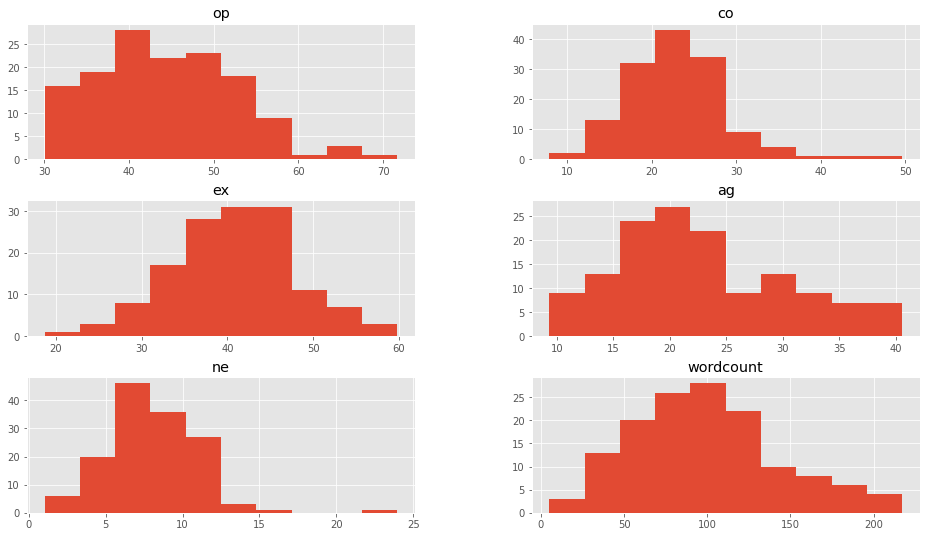

In [6]:
#Veremos graficamente nuestros data para tener una idea de la dispersión de los mismos
dataframe.drop(['categoria'],1).hist()
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


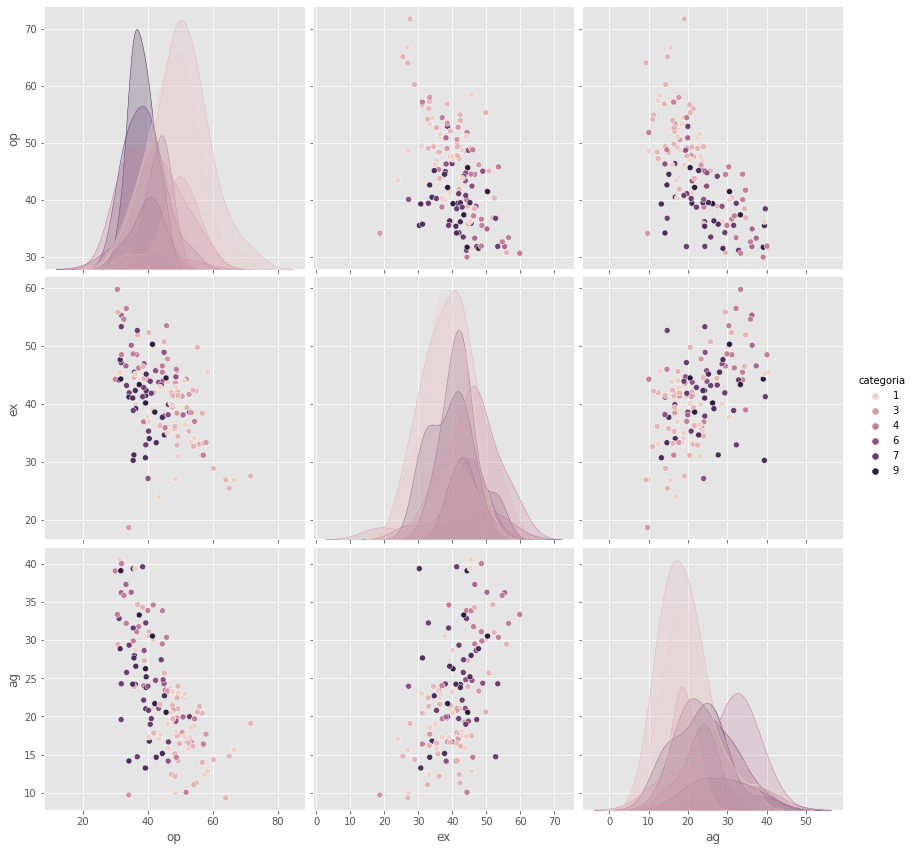

In [7]:
#En este caso seleccionamos 3 dimensiones: op, ex y ag 
#y las cruzamos para ver si nos dan alguna pista de su agrupación y la relación con sus categorías.
sb.pairplot(dataframe.dropna(), hue='categoria',size=4,vars=["op","ex","ag"],kind='scatter')

#Revisando la gráfica no pareciera que haya algún tipo de agrupación o correlación entre los usuarios y sus categorías

In [8]:
#Definimos la entrada
#Concretamos la estructura de data que utilizaremos para alimentar el algoritmo.
#Sólo cargamos las columnas op, ex y ag en nuestra variable X.
X = np.array(dataframe[["op","ex","ag"]])
y = np.array(dataframe['categoria'])
X.shape

(140, 3)

/var/folders/7n/jy1_ycd91snbbhld0x37jht80000gn/T/ipykernel_31175/195963678.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


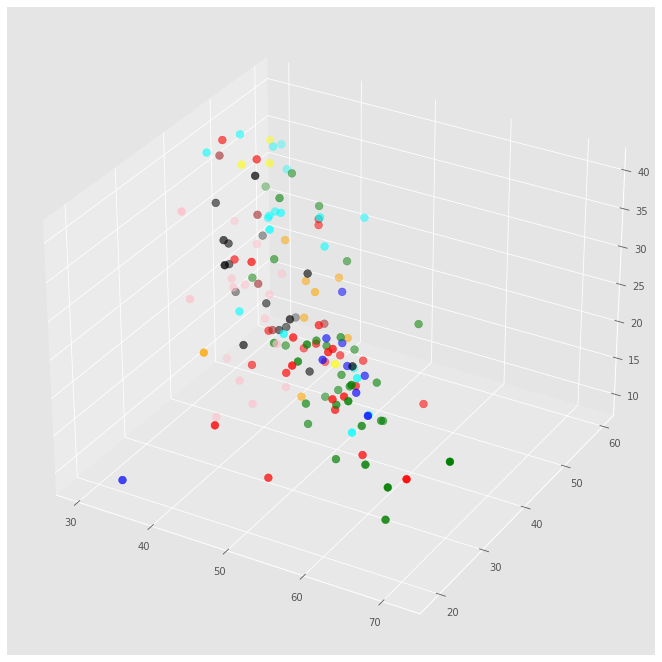

In [9]:
#Tenemos una gráfica en 3D con 9 colores representando las categorías.
fig = plt.figure()
ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple']
asignar=[]
for row in y:
    asignar.append(colores[row])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)

#Veremos si con K-means, podemos “pintar” esta misma gráfica de otra manera, con clusters diferenciados.

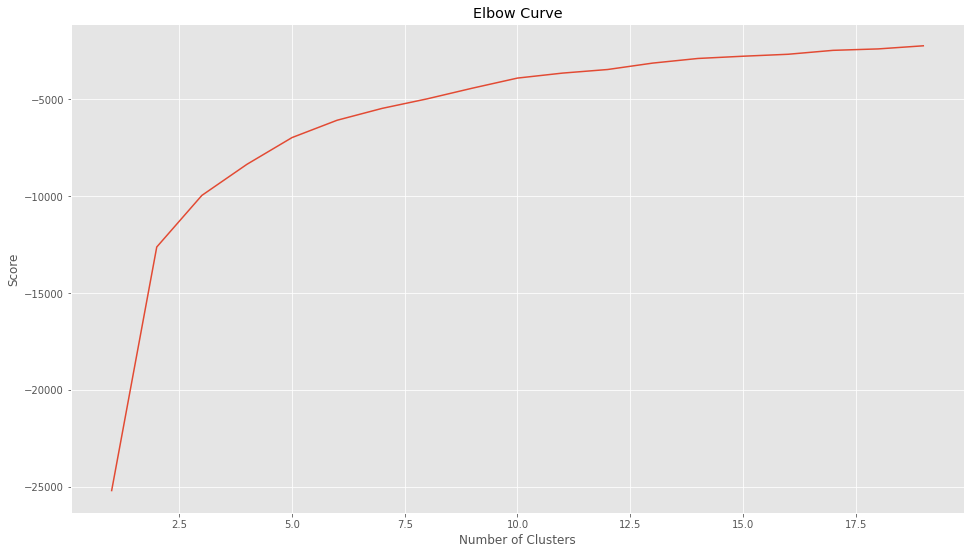

In [10]:
#Obtener el valor K
#Hallamos el valor de K haciendo una gráfica intentando hallar el “punto de codo”
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#En la siguiente referencia ver una explicación del Método del codo para la selección del número correcto de clusters k
# https://www.jacobsoft.com.mx/es_mx/k-means-clustering-con-python/

<p>Realmente la curva es bastante “suave”. Se considera a 5 como un buen número para K.</p>

<b>Pregunta 2: (20 puntos)</b> Según su criterio, ¿cuál tomarías y por qué?

<b>Respuesta 2:</b>

Primero, deberiamos de considerar que no queremos más de 9 clusters, ya que 9 es el número de categorias ya existentes. Luego la gráfica de codo se atenua de forma significativa a partir del valor 5, por lo que $k = 5$ me parece un término correcto, aún así, $k=6$ aun logra disminuir el valor de forma significativa en comparación con el resto de los valores donde se sueviza más.

Sin embargo, al diminuir el rango, podemos ver que la atenuación es más significativa desde el valor de $k=3$, por lo que según el tipo de clasificación que busquemos, este parece también un buen término.

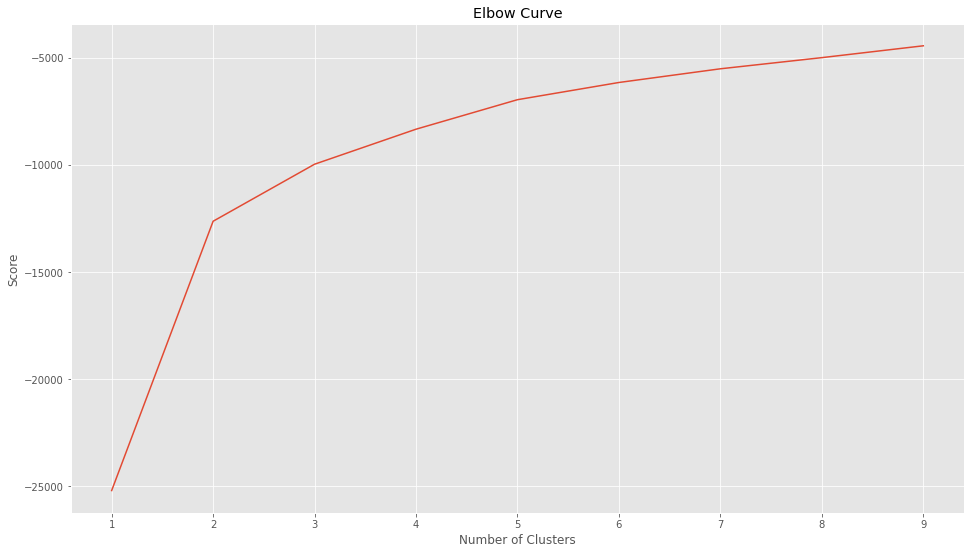

In [11]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [12]:
#Ejecutamos K-Means
#Ejecutamos el algoritmo para 5 clusters y obtenemos las etiquetas y los centroids.
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[40.078931   43.71085067 23.16550307]
 [42.73275924 33.0308789  21.11743814]
 [35.90241306 47.56828232 33.58748762]
 [50.42588653 40.66723528 17.30892463]
 [58.70462307 30.53566167 15.72207033]]


/var/folders/7n/jy1_ycd91snbbhld0x37jht80000gn/T/ipykernel_31175/3058339466.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


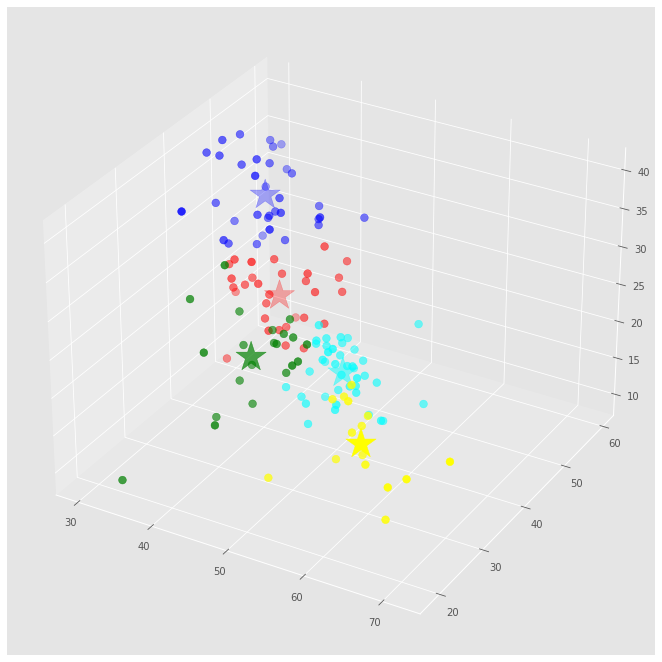

In [13]:
#Ahora se puede ver esto en una gráfica 3D con colores para los grupos y veremos si se diferencian:
# (las estrellas marcan el centro de cada cluster)

# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores = ['red','green','blue','cyan','yellow']
asignar = []
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

#Podemos ver que el Algoritmo de K-Means con K=5 ha agrupado a los 140 usuarios Twitter por su personalidad,
# teniendo en cuenta las 3 dimensiones que utilizamos: Openess, Extraversion y Agreeablenes. 
#Pareciera que no hay necesariamente una relación en los grupos con sus actividades de Celebrity.

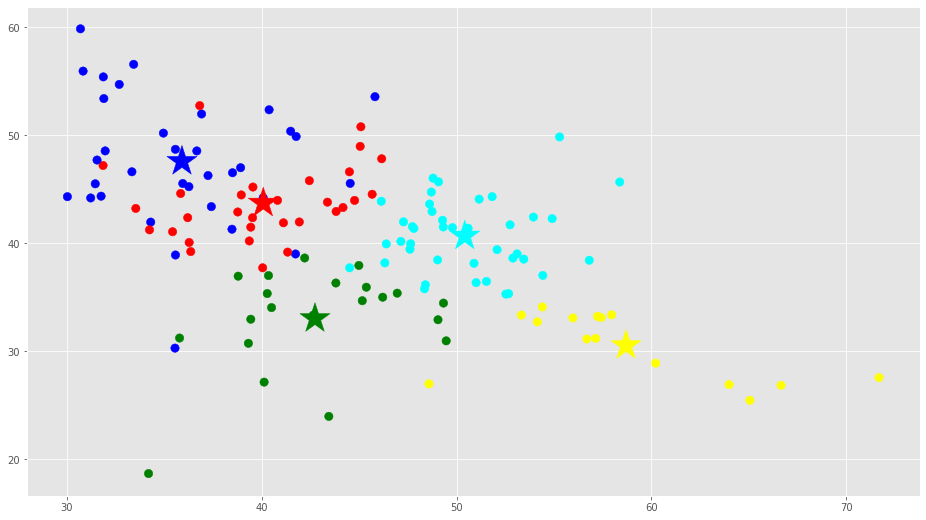

In [14]:
#Se tienen/generan 3 gráficas en 2 dimensiones con las proyecciones a partir de nuestra gráfica 3D 
# para que nos ayude a visualizar los grupos y su clasificación

#GRAFICA 1
# Getting the values and plotting it
f1 = dataframe['op'].values
f2 = dataframe['ex'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

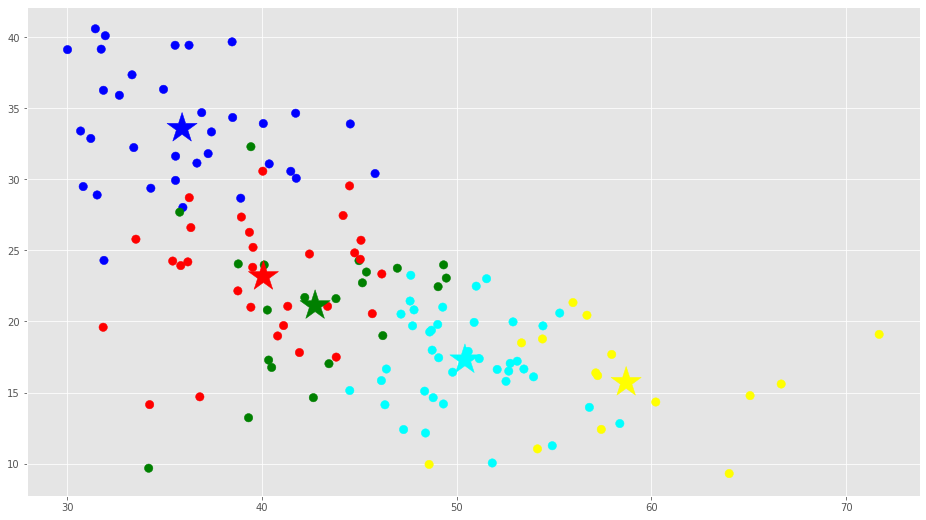

In [15]:
#GRAFICA 2
# Getting the values and plotting it
f1 = dataframe['op'].values
f2 = dataframe['ag'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

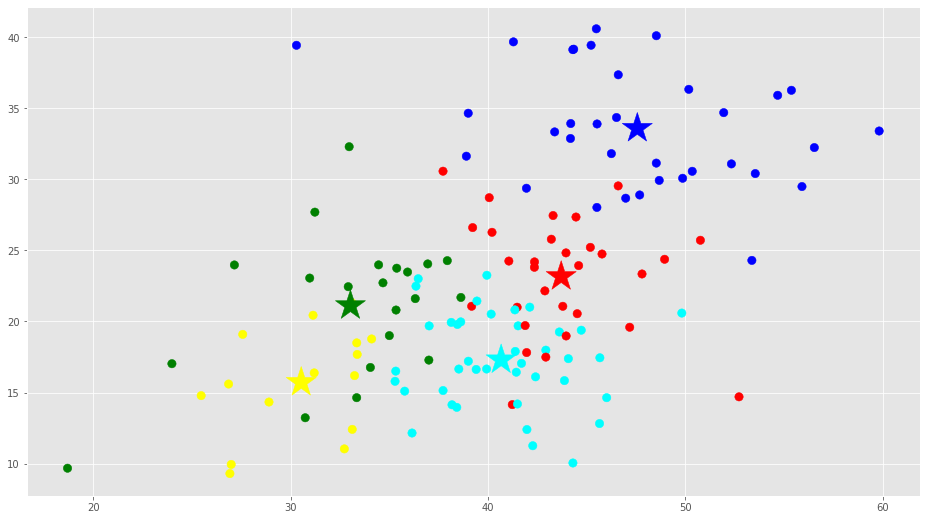

In [16]:
#GRAFICA 3
f1 = dataframe['ex'].values
f2 = dataframe['ag'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

#Se puede observar que están bastante bien diferenciados los grupos.

In [17]:
#Ahora bien, podemos ver cada uno de los clusters cuántos usuarios tiene:
copy =  pd.DataFrame()
copy['usuario']=dataframe['usuario'].values
copy['categoria']=dataframe['categoria'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,30
1,green,21
2,blue,34
3,cyan,40
4,yellow,15


In [18]:
#De igual manera podemos ver la diversidad en rubros laborales de cada uno.
#Por ejemplo en el grupo 0 (rojo), vemos que hay de todas las actividades laborales aunque predominan
# de actividad 1 y 2 correspondiente a Actores y Cantantes con 11 y 15 famosos
group_referrer_index = copy['label'] ==0
group_referrals = copy[group_referrer_index]

diversidadGrupo =  pd.DataFrame()
diversidadGrupo['categoria']=[0,1,2,3,4,5,6,7,8,9]
diversidadGrupo['cantidad']=group_referrals.groupby('categoria').size()
diversidadGrupo

#De categoría 3 “modelos” hay 6 sobre un total de 9.

,categoria,cantidad
0,0,NaN
1,1,4.0
2,2,4.0
3,3,1.0
4,4,1.0
5,5,NaN
6,6,4.0
7,7,7.0
8,8,7.0
9,9,2.0


In [19]:
#Buscaremos los usuarios que están más cerca a los centroids de cada grupo que podríamos decir que
# tienen los rasgos de personalidad característicos que representan a cada cluster:

#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

#El resultado de la consulta muestra la posicion en el array de usuarios

array([ 64, 120,  98,  21,  82])

In [20]:
#En este caso podemos ver que en los centros tenemos una modelo,
# un político, presentadora de Tv, locutor de Radio y un deportista.

users=dataframe['usuario'].values
for row in closest:
    print(users[row])

ierrejon
SarahPalinUSA
maria_patino
carmenelectra
JudgeJudy


In [21]:
#Clasificar nuevas muestras
#Finalmente podemos agrupar y etiquetar nuevos usuarios twitter con sus características y clasificarlos.
X_new = np.array([[45.92,57.74,15.66]]) #davidguetta

new_labels = kmeans.predict(X_new)
print(new_labels)

#Vemos el ejemplo con el usuario de David Guetta y nos devuelve que pertenece al grupo 1 (verde).

[0]


## Conclusiones

<p>El algoritmo de Clustering K-means es uno de los más usados para encontrar grupos ocultos, o sospechados en teoría sobre un conjunto de data no etiquetado. Esto puede servir para confirmar -o desterrar- alguna teoría que teníamos asumida de nuestros data o negocio. Y también puede ayudarnos a descubrir relaciones asombrosas entre conjuntos de data, que de manera manual, no hubiéramos reconocido. Una vez que el algoritmo ha ejecutado y obtenido las etiquetas, será fácil clasificar nuevos valores o muestras entre los grupos obtenidos.</p>

<p>Algunos casos de uso son:</p>
<ul>
    <li>Segmentación por Comportamiento: relacionar el carrito de compras de un usuario, sus tiempos de acción e información del perfil.</li>
    <li>Categorización de Inventario: agrupar productos por actividad en sus ventas</li>
    <li>Detectar anomalías o actividades sospechosas: según el comportamiento en una web reconocer un troll -o un bot- de un usuario normal</li>
</ul>

<p>Atención: Puede haber casos en los que <b>no existan grupos naturales</b>, o clusters que contengan una verdadera razón de ser. Si bien K-means siempre nos brindará “k clusters”, quedará en nuestro criterio reconocer la utilidad de los mismos o bien revisar nuestras features y descartar las que no sirven o conseguir nuevas. También tener en cuenta que en este ejemplo estamos utilizando como medida de similitud entre features la dis Euclideana pero podemos utilizar otras diversas funciones que podrían arrojar mejores resultados (como Manhattan, Lavenshtein, Mahalanobis, etc).</p>


<b>Pregunta 3: (50 puntos)</b> Escoja al menos 2 de las medidas de similitud antes mencionada, y haciendo uso de las implementaciones de las mismas en librería de Sklearn; muestre los resultados que se obtienen. Emita su criterio al respecto.

---

Cabe mencionar que dentro del algoritm de k-means de Skalearn no se encuentra implementadas otras distacias fuera de la euclideana, así que vamos a tomar  parte de nuestra implementación en ISODATA, y vamos a adaptarla para generar el algoritmo de k-means.

In [22]:
# diss:

# Ecuclideana:
from scipy.spatial.distance import euclidean
# Manhattan:
from scipy.spatial.distance import cityblock
# Chebyshev
from scipy.spatial.distance import chebyshev

In [26]:
# K -means
import random

def kmeans(data,k,dis='euclidea'):
  '''
  Función que clasifica data en k grupos a través del algoritmo k-medias.

  Parámetros
  ----------
  data : Lista de listas.
    Los patrones que deseamos clasificar.
    
  k : Entero
    Es la cantidad de grupos en que se quiere dividir el conjunto de data

  dis : Cadena
    Es la dis que se usará para aplicar el algoritmo. Por default
    se establece como la dis euclideana.

  Retorna 
  ----------
  labels : Lista
    Es una lista que indica el grupo al que pertenece cada patrón.
  centroides : Lista
    Es una lista que contiene los vectores donde se encuentran el centro del centroide
    despues de haber aplicado el algoritmo
  '''
  # Definimos la función de distancia
  if dis == 'euclidea':
    dis = euclidean
  elif dis == "manhattan":
    dis = cityblock
  elif dis == "chebyshev":
    dis = chebyshev

  # Iniciemos la distancia.
  centroides = centroides_i(data, k)
  
  while True:
    viejos_centroides = centroides
    labels = get_labels(data,centroides,dis)
    centroides = actualiza_centroides(data, labels, k)
    comparacion = np.array(viejos_centroides) == np.array(centroides)

    if (comparacion).all():
      break

  return labels, centroides


In [27]:
# FUNCIONES AUXILIARES:

def centroides_i(data,k):
  '''
  Función auxiliar para el algoritmo k-medias. Elige k centroides iniciales
  aleatorios dentro del rango de los patrones. 

  Parámetros
  ----------
  data : Lista de listas
    Los patrones que deseamos clasificar.
  
  k : Entero
    Es la cantidad de grupos en que se quiere dividir el conjunto de data.

  Retorna 
  ----------
  centroides : Arreglo de numpy
    Cada renglón del arreglo es un centroide generado de forma aleatoria.
  '''
  dim = data.shape[1]
  minimos = []
  maximos = []

  for i in range(dim):
    minimo = float('inf')
    maximo = float('-inf')

    for punto in data:
      minimo = min(punto[i], minimo)
      maximo = max(punto[i], maximo)
    
    minimos.append(minimo)
    maximos.append(maximo)

  centroides = np.zeros((k,dim))

  for i in range(k):
    for j in range(dim):
      centroides[i,j] = minimos[j] + (maximos[j]-minimos[j])*random.random()

  return centroides


def get_labels(data, centroides, dis):
  '''
  Función auxiliar para el algoritmo de k-means que genera la clasificación de 
  los patrones egú el centroide que tenga más cerca.

  Parámetros
  ----------
  datos : Lista de listas
    Los patrones que deseamos clasificar.

  centroides : Lista de listas
    Son los centroides con los que se determinará la pertenencia de los puntos
    a los grupos.

  Retorna 
  ----------
  labels : Lista
    Es una lista que indica el grupo al que pertenece cada punto, ordenado
    según el orden original de los datos. Se consideran los grupos 0, 1,..., k-1 
  '''
  labels = []
  for punto in data:
    min_dist = float('inf')
    label = None

    for i, centroide in enumerate(centroides):
      nueva_dist = dis(punto,centroide)
      if min_dist > nueva_dist:
        min_dist = nueva_dist
        label = i
    labels.append(label)
  return labels

def actualiza_centroides(data, labels, k):
  '''
  Función auxiliar para el algoritmo k-medias. Recalcula para cada grupo los
  centroides.

  Parámetros
  ----------
  data : Lista 
    Los patrones que deseamos clasificar..

  labels : Lista
    Es una lista que indica el grupo al que pertenece cada patrón.
  k : Entero
    Es la cantidad de grupos en que se quiere dividir el conjunto de data.

  Retorna 
  ----------
  nuevos_centroides : Lista de listas
    Devuelve los centroides recalculados según los data y su grupo de
    pertenencia según su label.
  '''
  dim = data.shape[1]
  nuevos_centroides = [[0]*dim for i in range(k)]
  contador = [0]*k 

  for punto, label in zip(data,labels):
    for i in range(dim):
      nuevos_centroides[label][i] += punto[i]
    contador[label] += 1

  for i in range(k):
    nuevos_centroides[i] = list(np.array(nuevos_centroides[i])/contador[i])

  return nuevos_centroides

----
### Manhattan

In [28]:
 # distacia manhattan
l, C = kmeans(X, 5, 'manhattan')

/var/folders/7n/jy1_ycd91snbbhld0x37jht80000gn/T/ipykernel_31175/2073458895.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


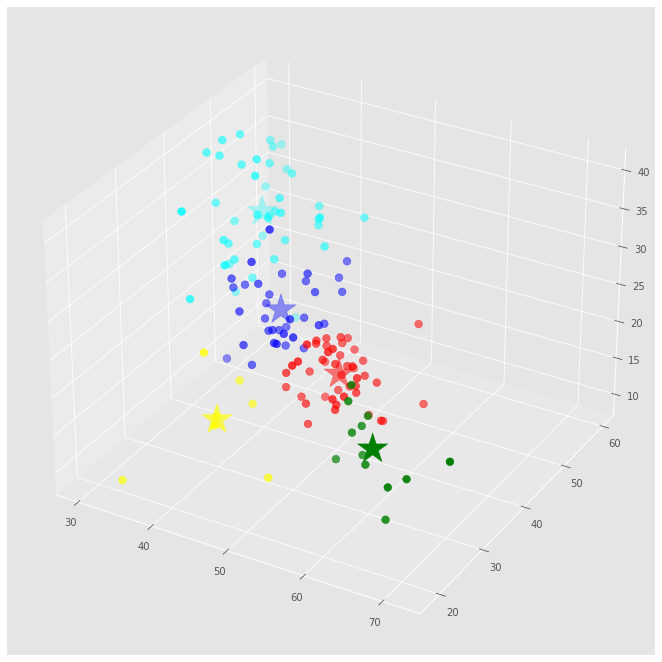

In [29]:
C = np.array(C)
colores = ['red','green','blue','cyan','yellow']
asignar = []
for row in l:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

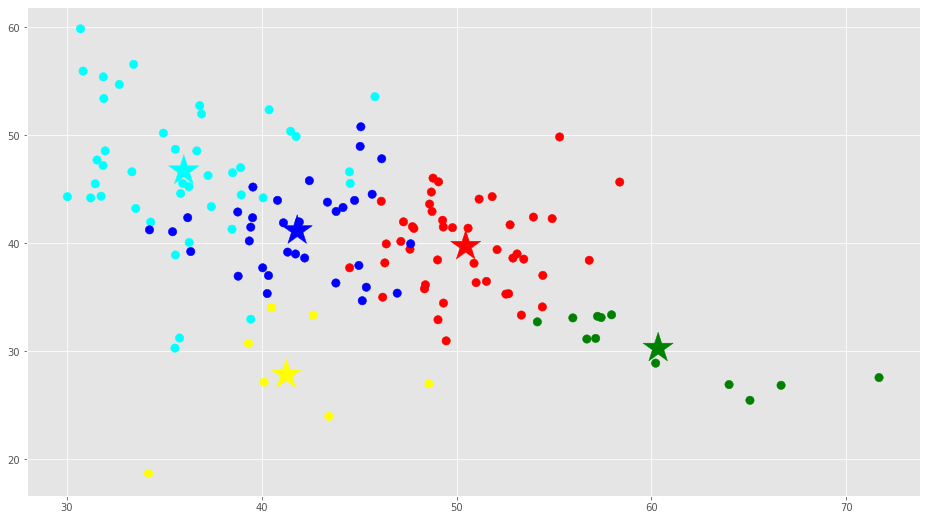

In [30]:
#GRAFICA 1
# Getting the values and plotting it
f1 = dataframe['op'].values
f2 = dataframe['ex'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

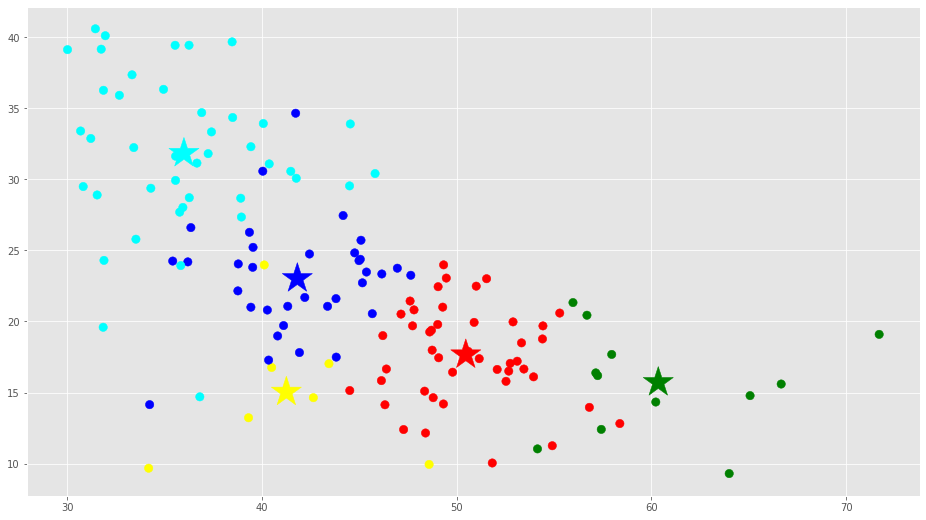

In [31]:
#GRAFICA 2
# Getting the values and plotting it
f1 = dataframe['op'].values
f2 = dataframe['ag'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

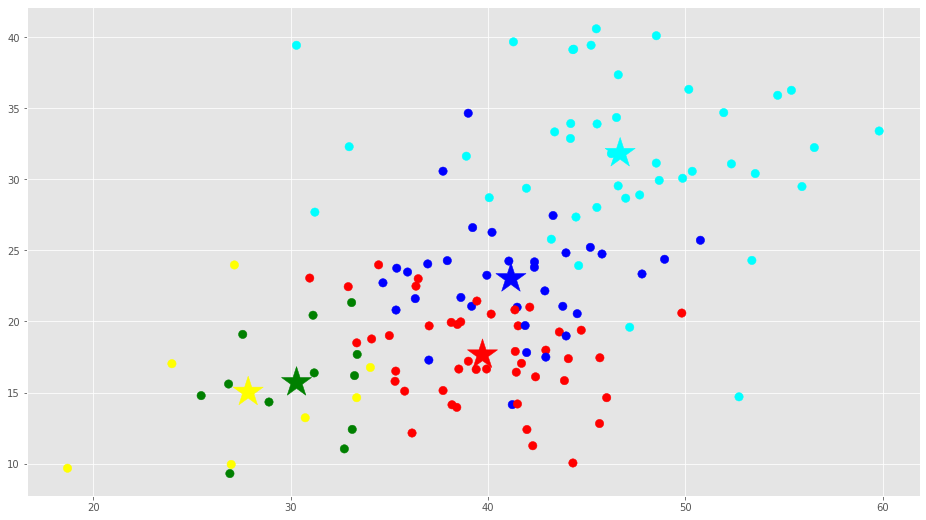

In [32]:
#GRAFICA 3
f1 = dataframe['ex'].values
f2 = dataframe['ag'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

In [33]:
#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(C, X)

users=dataframe['usuario'].values
for row in closest:
    print(users[row])

carmenelectra
foofighters
ierrejon
maria_patino
Rep_Hunter


----

### Chebyshev

In [37]:
 # distacia chebyshev
l, C = kmeans(X, 5, 'chebyshev')

/var/folders/7n/jy1_ycd91snbbhld0x37jht80000gn/T/ipykernel_31175/2073458895.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


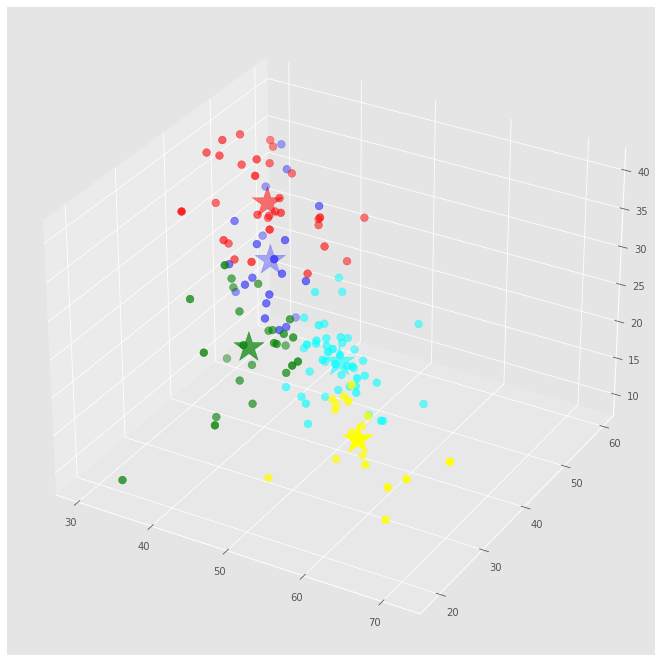

In [38]:
C = np.array(C)
colores = ['red','green','blue','cyan','yellow']
asignar = []
for row in l:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

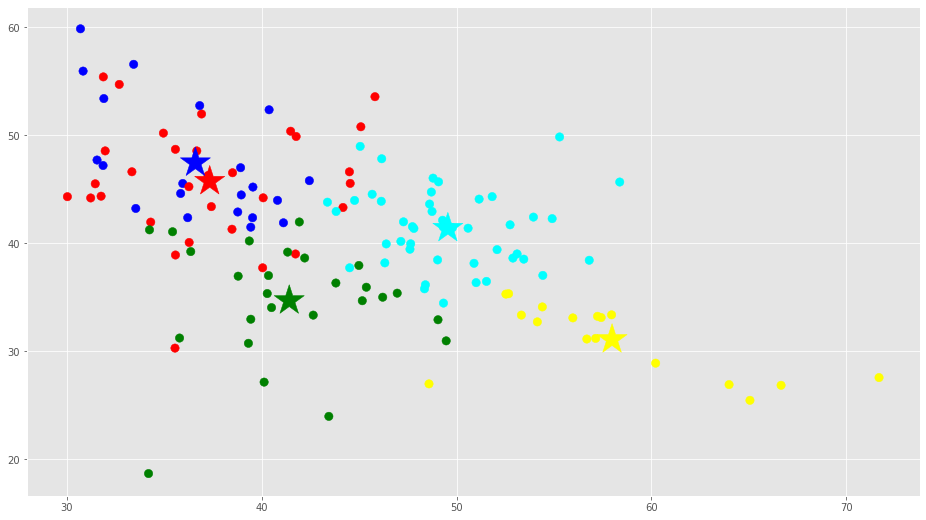

In [39]:
#GRAFICA 1
# Getting the values and plotting it
f1 = dataframe['op'].values
f2 = dataframe['ex'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

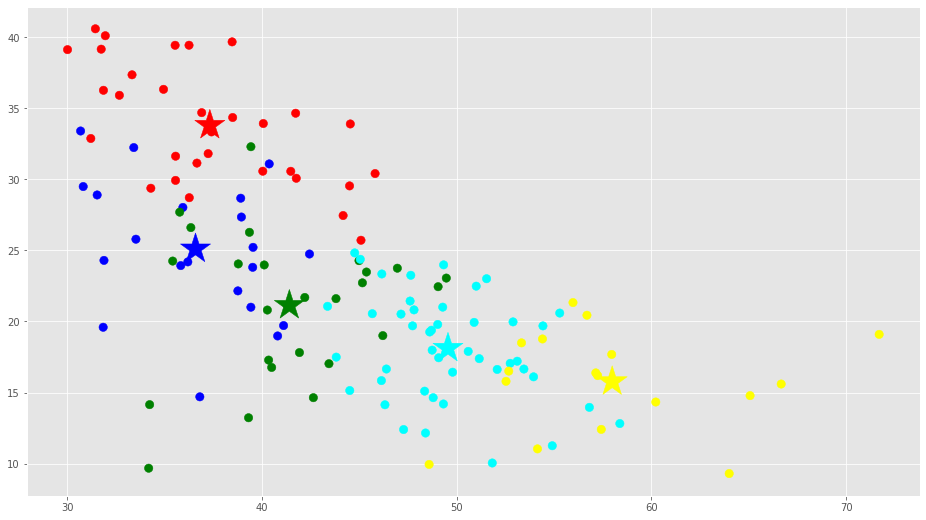

In [40]:
#GRAFICA 2
# Getting the values and plotting it
f1 = dataframe['op'].values
f2 = dataframe['ag'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

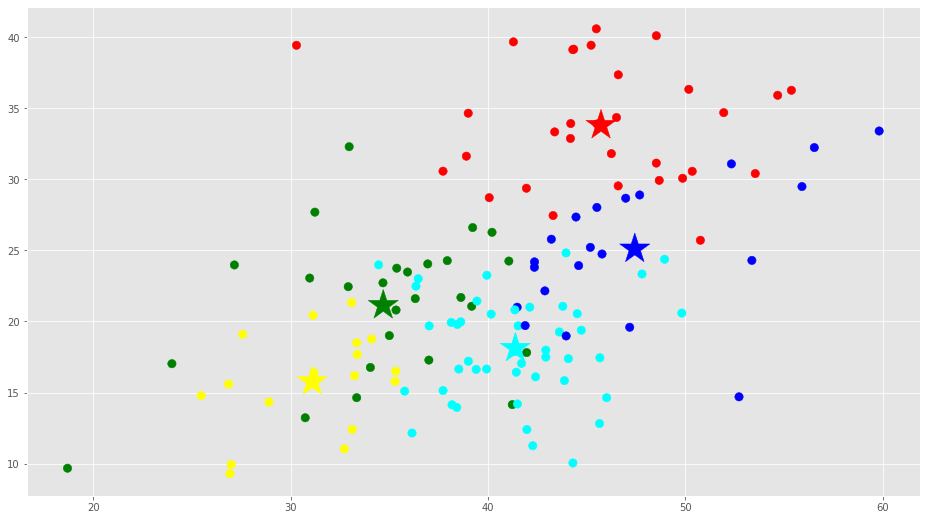

In [41]:
#GRAFICA 3
f1 = dataframe['ex'].values
f2 = dataframe['ag'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

In [42]:
#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(C, X)

users=dataframe['usuario'].values
for row in closest:
    print(users[row])

SerranoIsmael
kobebryant
pabloalboran
carmenelectra
JudgeJudy


Como era de esperarse, el algoritmo siempre nos da 5 clusters. Aunque estos en general pueden verse bastante parecidos, es sobre todo en los patrones de frontera donde se encuentran la mayoria de las diferencias, y debido a que se calculan los nuevos clusters bajo diss diferentes, estos se tienden a mover más, es por eso que aquellos regsitros más cercanos, cambia según la dis. 

Es dificil definir cual de estas diss da una mejor clasificación, todas tienen sus ventajas, y según lo que deseemos alguna presentará una ventaja en la clasificación. Sin embargo, en este caso, la dis entre patrones, y su cercaia es considerando de forma secuencias en un rango, la mejor dis que podríamos elegir es la euclidiana.